In [1]:
from __future__ import division
from importlib import reload
from modules import * 
import pickle
import csv
fig_savedir = '../data/figures/'

'''
to do 
- in order to test moved reward, need to work on 
    - recall of memory functions 
    - cosh function / envelopes
    - weighting with similarity score?
    - bootstrapping from EC to MF
        - function that controls switch from EC to MF? 
        - also a decay function, how to tune envelope parameter? 

- genetic algorithms

'''

'\nto do \n- in order to test moved reward, need to work on \n    - recall of memory functions \n    - cosh function / envelopes\n    - weighting with similarity score?\n    - bootstrapping from EC to MF\n        - function that controls switch from EC to MF? \n        - also a decay function, how to tune envelope parameter? \n\n- genetic algorithms\n\n'

In [2]:
grid_params = {
    'y_height':     10, 
    'x_width':      10,
    'walls':        False,
    'rho':          0,
    'maze_type':    'none',
    'port_shift':   'none' 
}

#make environment
maze = eu.gridworld(grid_params)

(7, 7)


In [3]:
def reset_agt(agent_params):
        ## some stupid reward placement shit -- replace later
    if agent_params['load_model'] == True:
        if agent_params['rwd_placement'] == 'training_loc':
            maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])
        if agent_params['rwd_placement'] == 'moved_loc':
            maze.set_rwd([(int(grid_params['y_height']/4),int(3*grid_params['x_width']/4))])
        
    else:
        maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])

    # make agent 
    agent_params = sg.gen_input(maze, agent_params)
    MF,opt = ac.make_agent(agent_params, freeze=False)

    if agent_params['use_EC']:
        #agent_params['cachelim'] = int(0.5*np.prod(maze.grid.shape))
        agent_params['EC'] = ec.ep_mem(MF,agent_params['cachelim'])
    
    run_dict = {}
    run_dict = {
        'NUM_EVENTS':   300,
        'NUM_TRIALS':   2000,
        'environment':  maze,
        'agent':        MF,
        'optimizer':    opt,
        'agt_param':    agent_params
    }
    
    return run_dict

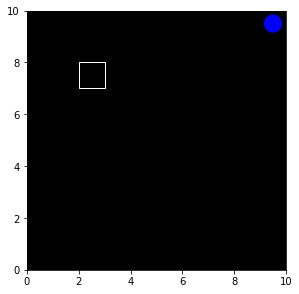

In [4]:
agent_params = {
        'load_model':   True,
        'load_dir':     '../data/outputs/gridworld/openfield{}{}.pt'.format(grid_params['x_width'],grid_params['y_height']),
        'rwd_placement':'moved_loc',
        'action_dims':  len(maze.actionlist),
        'lin_dims':     500,
        'batch_size':   1,
        'gamma':        0.98, #discount factor
        'eta':          5e-4,
        'temperature':  1,
        'use_EC':       True,
        'cachelim':     300, # memory limit should be ~75% of #actions x #states
        'state_type':   'conv'
    }
run_dict = reset_agt(agent_params)
gp.plot_env(maze)


In [5]:
run_dict = reset_agt(agent_params)
#expt.run_full_trials(run_dict, pen = -0.0)
expt.run_truncated_trials(run_dict, pen=-0.01, use_EC=True)

../memory/episodic.py:110: RuntimeWarning: overflow encountered in cosh
  return np.round(1 / np.cosh(p / envelope), 8)


[16:36:22]  Trial 1 TotRew = -2.9899999999999802 (0.252s)


../memory/episodic.py:108: RuntimeWarning: overflow encountered in cosh
  return mfc*np.round(1 / np.cosh(p / envelope), 8)


[16:37:30]  Trial 11 TotRew = -2.9899999999999802 (68.373s)
[16:40:13]  Trial 21 TotRew = -2.9899999999999802 (162.563s)
[16:42:35]  Trial 31 TotRew = -2.9899999999999802 (141.730s)
[16:44:36]  Trial 41 TotRew = 0.3299999999999996 (121.321s)
[16:47:02]  Trial 51 TotRew = -2.9899999999999802 (145.897s)
[16:49:48]  Trial 61 TotRew = -2.9899999999999802 (166.000s)
[16:52:18]  Trial 71 TotRew = -2.9899999999999802 (150.503s)
[16:54:49]  Trial 81 TotRew = -0.7000000000000013 (150.271s)
[16:57:15]  Trial 91 TotRew = 0.71 (146.539s)
[16:59:02]  Trial 101 TotRew = -2.9899999999999802 (107.272s)
[17:01:10]  Trial 111 TotRew = -2.9899999999999802 (127.915s)
[17:03:42]  Trial 121 TotRew = -2.9899999999999802 (151.280s)
[17:05:55]  Trial 131 TotRew = -2.9899999999999802 (133.170s)


KeyboardInterrupt: 

In [ ]:
for i in range(len(agent_params['EC'].cache_list)):
    test_key = list(agent_params['EC'].cache_list.keys())[i]
    x = agent_params['EC'].cache_list[test_key][2]
    print("====\n",x)
    if x==run_dict['environment'].rwd_loc[0]:
        agent_params['EC'].recall_mem(test_key,1, decay=1000, prints=True)

In [6]:
policy_loss = run_dict['total_loss'][0]
value_loss = run_dict['total_loss'][1]
tot_reward = run_dict['total_reward']
trial_length = run_dict['trial_length']
#pick = [tot_reward, policy_loss, value_loss, trial_length]
#pickle.dump(pick, open("pickles/initial_training.p", "wb"))

In [ ]:
ac.torch.save(run_dict['agent'],agent_params['load_dir'])

In [ ]:
vv, pp = ac.snapshot(agent=run_dict['agent'], maze =run_dict['environment'])

gp.plot_polmap(run_dict['environment'], pp)
gp.plot_valmap(run_dict['environment'], vv, p_range = [0,1])

In [ ]:
reload(gp)
ttt = ac.mem_snapshot(run_dict['environment'], agent_params['EC'], trial_timestamp=1, decay=1)
gp.plot_polmap(run_dict['environment'],ttt)

In [ ]:
fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(policy_loss)
ax[0].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[0].set_ylabel('Policy Loss')
ax[1].plot(value_loss)
ax[1].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[1].set_ylabel('Value Loss')

#ax[0].arrow(2000, max(policy_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')
#ax[1].arrow(2000, max(value_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')

#plt.savefig('../data/figures/loss_after_trunc_training.svg', format='svg')
plt.show()
plt.close()

In [ ]:
x = -1
print(value_loss[x])
print(policy_loss[x])

In [ ]:
vv, pp = ac.snapshot(agent=run_dict['agent'], maze =run_dict['environment'])
reload(gp)
gp.plot_polmap(run_dict['environment'], pp)
gp.plot_valmap(run_dict['environment'], vv, p_range=[0,1.5])

In [ ]:
EC = agent_params['EC']

In [ ]:
import time
meas_time = time.time()
x = np.asarray(list(agent_params['EC'].cache_list.keys()))
#x = np.asarray([*agent_params['EC'].cache_list.keys()])
print(time.time() - meas_time)

In [ ]:
reload(ec)
test_case = x[0]+ 0.3*(np.random.randn(500))
key, index, sim = EC.cosine_sim(test_case)
print(key[0:10], index, sim)
EC.recall_mem(key, timestep=1)


In [ ]:
ac.torch.save(run_dict['agent'],agent_params['load_dir'])